# Continued EDA for Senior Thesis
Adding Geopatial Bounding

## Dependencies

In [1]:
# libraries that I may potential need:
import pandas as pd
import math
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.warp
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
import geopandas as gpd
from shapely.geometry import Point, box
from pandas.plotting import scatter_matrix
import random
import seaborn as sns
import fiona

## Variables

### Used Google Translate to reencocde variable names:
| original variable name | translated variable name |
| --- |--- |
| gattung_botanisch  | botanical genus     |
| gattung_deutsch    | German genus        |
| art_botanisch      | botanical species   |
| art_deutsch        | German species      |
| alleebaum          | avenue tree         |
| hoehe              | height              |
| stammdurchmesser   | trunk diameter      |
| stammumfang        | trunk circumference |
| kronendurchmesser  | crown diameter      |
| baumpatenschaft    | tree sponsorship    |

In [2]:
# set path to data set
path_tree               = '../data/data_gov_de/trees/baeume.json'
path_parks              = '../data/data_gov_de/parks/parkanlagen.json'
path_cemeteries         = '../data/data_gov_de/cemeteries/friedhoefe.json'
aggregate_hulls_kml     = '../data/derived/aggregate_hulls.kml'
path_test_kml           = '../data/derived/rostock_trees_test_subset.kml'

# create german to english variable name map
recoded_column_names = {
    'gattung_botanisch' : 'botanical_genus'     ,
    'gattung_deutsch'   : 'German_genus'        ,
    'art_botanisch'     : 'botanical_species'   ,
    'art_deutsch'       : 'German-species'      ,
    'alleebaum'         : 'avenue_tree'         ,
    'hoehe'             : 'height'              ,
    'stammdurchmesser'  : 'trunk_diameter'      ,
    'stammumfang'       : 'trunk_circumference' ,
    'kronendurchmesser' : 'crown_diameter'      ,
    'baumpatenschaft'   : 'tree_sponsorship'    ,
    'bezeichnung'   : 'designation'    ,
    }

# set standard deviation limit to constrain outliers
sd_limit = 3

# isolate cohorts for analysis that are not outliers and have less than n units min_count = 50
min_count = 35

# Gausian smoother coefficient
smother_sd = 1/2

## Functions

In [3]:
def kml_export(gdf:gpd.GeoDataFrame, path:str, espg:int = 4326):
    """
    # Export a GeoPandas dataframe as a *.kml file
    ## Expects a gpd.DataFrame.
    ## Path literal must end in '.kml'.
    """
    # depenencies
    import fiona
    
    # enable KML support
    fiona.drvsupport.supported_drivers['KML'] = 'rw'
    # cast to required CRS
    export_gdf = gdf.to_crs(epsg=4326)
    # export
    export_gdf.to_file(path, driver='KML')

def CRS_printer(gpd:gpd.GeoDataFrame):
    """
    # Prints the current Cordiante Reference System (CRS) for a GeoPandas (gpd) Dataframe.
    ## Expects:
    - a gpd.DataFrame object
    """
    if hasattr(gpd, 'crs'):
        print(f"CRS Object: {gpd.crs}")
        return gpd.crs
    else:
        print("No explicit CRS found using geojson library.")

def list_printer(a_list:list, number_of_items_to_print:int = 10000, span:int=80):
    """
    # Formated list printer
    ## Expects: 
     - A list like object
     - number of items from list to print. Default 10000
     - max length of page in. Assumes terminal is using fixed width font. Default 80
    ## Returns: Prints a formated list.
    """
    counter = 1
    list_len = len(a_list)
    max_len = len(max(a_list, key=len)) + 2
    if span > max_len:
        cols = round(span / max_len )
    else: return f'span {span} must be greater than len of longest item in list {max_len} +2'
    for i in a_list:
        if counter > number_of_items_to_print:
            break
        elif counter % cols == 0:
            print(f'{i:^{max_len}}')
        else: 
            print(f'{i:^{max_len}}', end= ' | ')
        counter += 1

def round_to_nearest_n(x, base):
    """
    # Rounds a value to the nearest multiple of 'base'.
    """
    return base * round(x / base)

def series_limit(series:pd.Series, sd_limit:int= 1) -> pd.Series:
    """
    # Mask values in a pandas series greater or equal to a limit.
    Limit defined by the number of standard devations away from the series mean the value is.
    Assumes a guasian distribution.
    """
    sample_sd = series.std()
    sample_mean = series.mean()
    limit = sample_mean + (sample_sd*sd_limit)
    mask = series <= limit
    return mask 

## Load Tree Data

In [4]:
# read GeoJson data into a GeoPandas DF
tree_gdf = gpd.read_file(path_tree, encoding='utf-8')

## Clean Tree Data

### translate variable names

In [5]:
# map translated variable names
tree_gdf = tree_gdf.rename(columns=recoded_column_names)

### split variable

In [6]:
# Split common name and species variable and create two new features
# - botanical_species_formal_name
# - botanical_species_common_name
tree_gdf[['botanical_species_formal_name', 'botanical_species_common_name']] = tree_gdf['botanical_species'].str.split(' „', expand=True).fillna(pd.NA)
tree_gdf['botanical_species_common_name'] = tree_gdf['botanical_species_common_name'].str.replace('“', '')

# Create mask for botanical_species_formal_name containing the string 'species'
# - We are isolating units where a generalization from a species to a genus was made.
mask_botanical_species_formal_name = tree_gdf['botanical_species_formal_name'].str.contains('species')
# set masked recs to NA
tree_gdf.loc[mask_botanical_species_formal_name, 'botanical_species_formal_name'] = pd.NA

### list unique species

In [7]:
# aint-subset units whose species has been generalized to a genus to a list
species = tree_gdf['botanical_species_formal_name'][~mask_botanical_species_formal_name].unique().tolist()

### mask outliers

In [8]:
# we create a mask to subset by trees whose height within 
# `sd_limit` standard deviations of the mean height
# - Note: The tallest tree in Germany is about 68 meters.
# - Trees taller than that are excluded.
mask_height = series_limit(tree_gdf['height'],sd_limit)

# we create a mask to subset by trees whose trunk_diameter is within 
# `sd_limit` standard deviations of the mean trunk_diameter
mask_trunk_diameter = series_limit(tree_gdf['trunk_diameter'],sd_limit)

# we create a mask to subset by trees whose trunk_circumference is within 
# `sd_limit` standard deviations of the mean trunk_circumference
mask_trunk_circumference = series_limit(tree_gdf['trunk_circumference'], sd_limit)

# we create a mask to subset by trees whose crown_diameter is within 
# `sd_limit` standard deviations of the mean crown_diameter
mask_crown_diameter = series_limit(tree_gdf['crown_diameter'],sd_limit)

# generate a uniform mask that excludes outliers across all continuious variables
# - Note: We do not drop these units, as these are still trees 
#         and may contribute to a future competitive density feature.
mask_non_outlier = mask_height & mask_trunk_diameter & mask_trunk_circumference & mask_crown_diameter

# isolate cohorts for analysis sans-outliers, having >= n units 
# counts by species of non outliers.
non_outlier_cohort_counts = tree_gdf[mask_non_outlier].groupby('botanical_species_formal_name')\
    ['botanical_species_formal_name'].count()
# list of cohorts that meet minimum representation
valid_species = non_outlier_cohort_counts[non_outlier_cohort_counts > min_count].index.to_list()

# mark those records whoes species cohort meets minimum representation...
tree_gdf['qualified_species_representation'] = tree_gdf['botanical_species_formal_name'].isin(valid_species)
# ... and that do not contain outliers.
tree_gdf['in_qualified_cohort'] = tree_gdf['botanical_species_formal_name'].isin(valid_species) & mask_non_outlier

### correcting digit preference bias
Note: See EDA_20260209 for evidence of rounding bias.

In [9]:
# generate features with gausian smoother

# round height to nearest integer ...
tree_gdf['height_standardized'] = tree_gdf['height'].round()
# ...and apply smoother:
tree_gdf['height_standardized'] = tree_gdf['height_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round crown_diameter to nearest integer ...
tree_gdf['crown_diameter_standardized'] = tree_gdf['crown_diameter'].round()
# ...and apply smoother:
tree_gdf['crown_diameter_standardized'] = tree_gdf['crown_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round trunk_circumference to nearest 9th centimeter ...
tree_gdf['trunk_circumference_standardized'] = tree_gdf['trunk_circumference'][tree_gdf['trunk_circumference'].notna()].apply(lambda x: round_to_nearest_n(x, base=9))
# ...and apply smoother:
tree_gdf['trunk_circumference_standardized'] = tree_gdf['trunk_circumference_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*9))

# round trunk_diameter to nearest 3rd centimeter ...
tree_gdf['trunk_diameter_standardized'] = tree_gdf['trunk_diameter'][tree_gdf['trunk_diameter'].notna()].apply(lambda x: round_to_nearest_n(x, base=3))
# ...and apply smoother:
tree_gdf['trunk_diameter_standardized'] = tree_gdf['trunk_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*3))


## Generate abstraction features

In [10]:
# generate baseline abstraction feature: volume
tree_gdf['volume_m^2'] = tree_gdf['height_standardized'] * (math.pi*((tree_gdf['crown_diameter_standardized']/2)**2))
# generate baseline abstraction feature: cover_area
tree_gdf['cover_area_m^2'] = (math.pi*((tree_gdf['crown_diameter_standardized']/2)**2))

## Review

In [11]:
tree_gdf.sample(5)

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,...,botanical_species_formal_name,botanical_species_common_name,qualified_species_representation,in_qualified_cohort,height_standardized,crown_diameter_standardized,trunk_circumference_standardized,trunk_diameter_standardized,volume_m^2,cover_area_m^2
34982,a88c0d5e-c0b3-4d1b-b596-11a2045ec2a6,Populus,Pappel,Populus x canadensis,Kanada-Pappel,False,34.0,58.57,184.00,16.0,...,Populus x canadensis,<NA>,True,True,33.931382,15.271689,179.852250,58.969920,6215.350076,183.174091
7405,dfbddec6-3e0e-42f4-bec4-a9bf893bf246,Tilia,Linde,Tilia platyphyllos,Sommer-Linde,True,5.0,16.00,50.27,3.0,...,Tilia platyphyllos,<NA>,True,True,4.424552,2.612873,54.337297,15.719320,23.724431,5.361996
7083,2723c903-a6b2-4d22-a871-7dd9470ce1bf,Tilia,Linde,Tilia cordata,Winter-Linde,True,10.0,42.34,133.00,8.0,...,Tilia cordata,<NA>,True,True,10.897194,6.726719,129.783981,42.243466,387.267534,35.538281
43324,3480b4c3-7c00-4b82-afeb-b15c75abaace,Alnus,Erle,Alnus glutinosa,Schwarz-Erle,False,5.0,15.00,47.12,2.0,...,Alnus glutinosa,<NA>,True,True,4.942472,2.230624,41.775295,16.611639,19.314647,3.907892
9716,891b1cd1-b03b-4053-bb48-4afdddd3db66,Prunus,Kirsche,Prunus padus,Trauben-Kirsche,False,4.5,6.37,20.00,2.1,...,Prunus padus,<NA>,True,True,3.769443,1.755295,22.213808,6.790552,9.121525,2.419860


Sample size = 27:


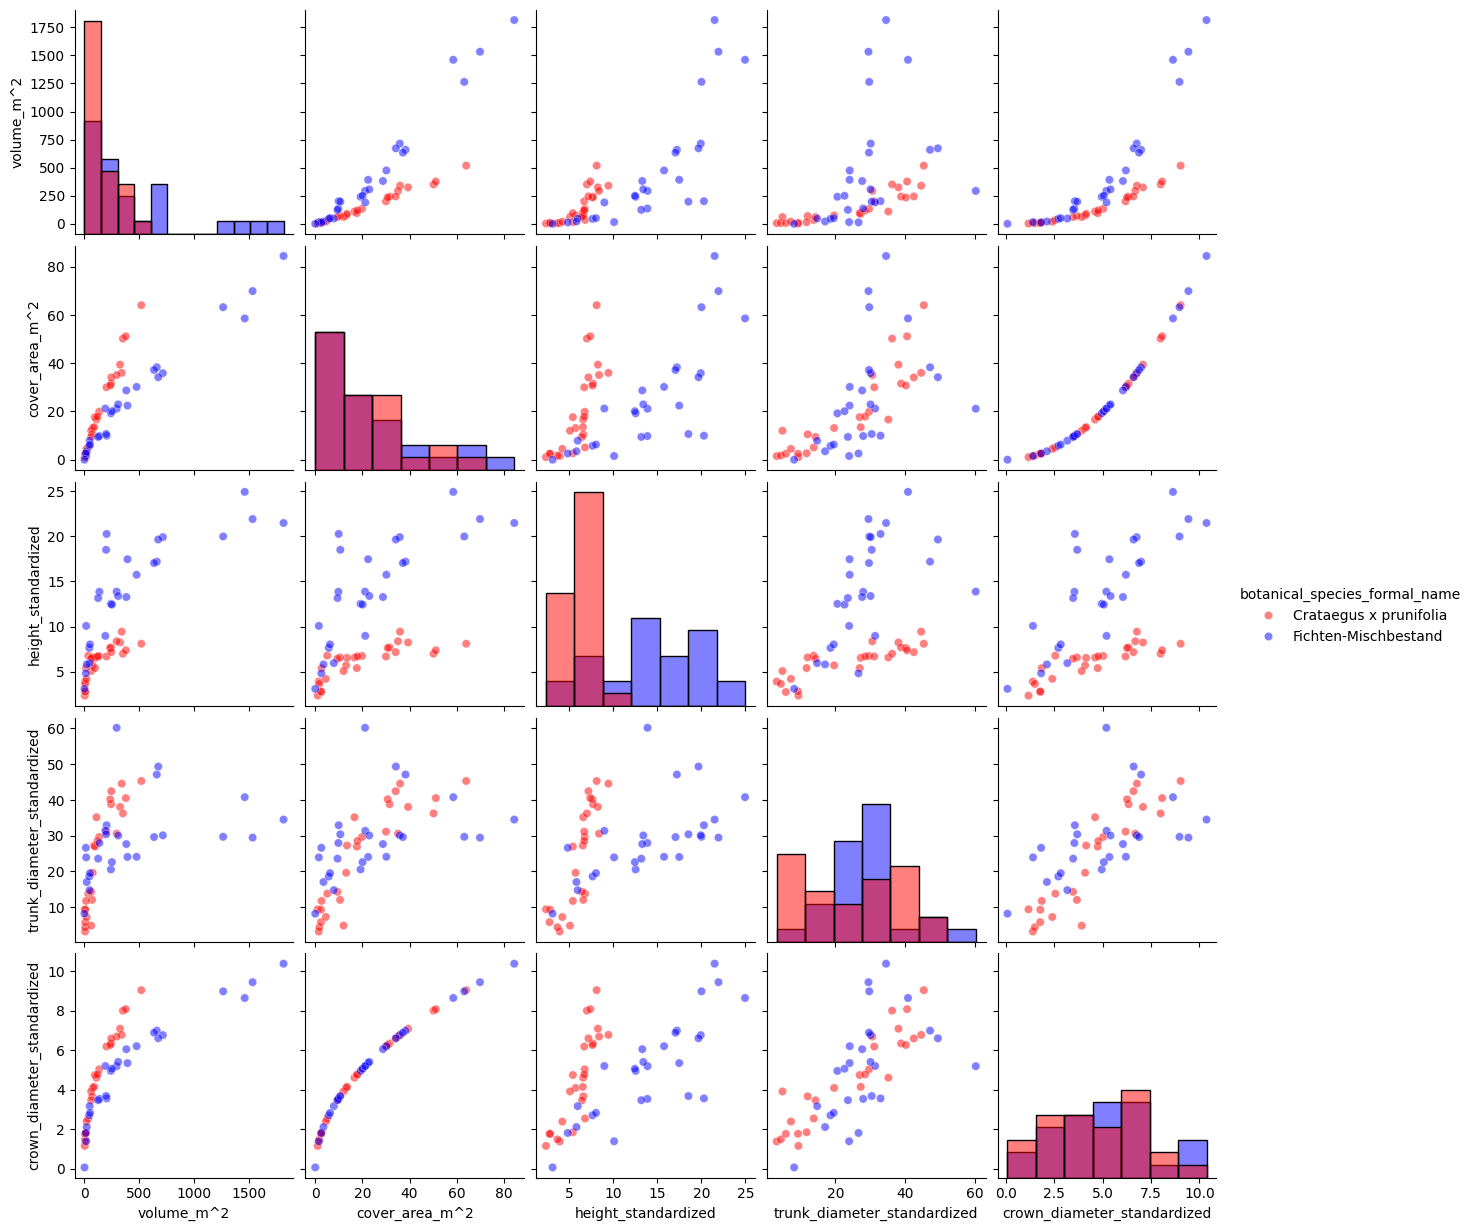

In [12]:
# matrix by species - comparison

## randomly select two valid species
rand_species_A = random.choice(valid_species)
rand_species_B = random.choice(valid_species)

# subset by species A
subset_A_with_labels = tree_gdf.loc[(tree_gdf['botanical_species_formal_name'] == rand_species_A) & 
                             (tree_gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume_m^2','cover_area_m^2','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# subset by species B
subset_B_with_labels = tree_gdf.loc[(tree_gdf['botanical_species_formal_name'] == rand_species_B) & 
                             (tree_gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume_m^2','cover_area_m^2','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# sample from each species 70% of the size of the smallest population
sizeA = subset_A_with_labels.shape[0]
sizeB = subset_B_with_labels.shape[0]
size = [sizeA if sizeA <= sizeB else sizeB]
size = round(size[0]*.7)
print(f'Sample size = {size}:')

# join subsets (Interesting that there is no gpd.concat. gpd relies on pd.conccat)
subset_with_labels = pd.concat([subset_A_with_labels.sample(size),subset_B_with_labels.sample(size)])

# pairplot
sns.pairplot(subset_with_labels, 
             hue='botanical_species_formal_name', 
             palette={rand_species_A: 'red', rand_species_B: 'blue'},
             diag_kind='hist', # Can also use 'kde' for smooth curves
             plot_kws={'alpha': 0.5})


# EDA - Round 2

### Remember:
Copernicus 10m pixel desity measurment is the response varaible

### Consideration → Convert to Copernicus CRS first?
Copernicus uses EPSG:3035

### General Defintions and rules
- Rule: Competition is constrained by polygon membership

- Define radius (r) for competition and diveristy
  - Notes on Neighborhood Competition Indices" (NCI) 
    - esajournals.onlinelibrary.wiley.com/doi/10.1002/ecs2.1273
    - It appears that influence tapers beyond 10 meters
  - Max crown_diameter in dataset is 21.95891198439781.
  - So, we could pull
    -  20 meters from trunk (Uniform)
    -  or 10 meters from edge of radius (Dynamic Crown-scaled radius)
  Note: 
    - We do not break sampling frame.  
    - Trees across polygon boundaries, but within a radius are not considered.

- Define Polygon edge buffer
  - (We are modeling the public forest network)

- Polygon buffer for inclusion in study
  - Buffer outside the edge risks inclusion unobserved trees.
  - Need to be able to adjust this dynamically
  - Or...  Make a choice on a park by park basis after manual review?

### For each tree:
- Define whether it is in a:
  - cemetery polygon
  - parks polygon
- Mark the apporpreate (bezeichnung) for each.
- Mark it's euclidian distance to the edge of the polygon
- Define denisty
  - n_neighbors: (count excluding self)
  - crown_area_sum proxy: sum of crown_diameter^2
- Define diversity
  - species_richness: number of unique species
  - shannon_index: robust diversity index

### For each municipal polygon
- Polygon-level density
- Tree-level local density
- Cross-scale competition
- Area (m^2)
- Perimiter (m^2)

### Validate
- Export inclusive trees as *.klm files and review in Google Earth on a per park basis


## Initial steps

- Load public bounding boxes.
- Convert CRS.
- Build basic features.
- Join to Trees Data

In [13]:
# load parks polygons
parks_gdf = gpd.read_file(path_parks, encoding='utf-8')
# load cemeteries polygons
cem_gdf = gpd.read_file(path_cemeteries, encoding='utf-8')

In [14]:
# Check cordiante reference system (CRS) for all loaded GeoJsons matches
CRS_printer(tree_gdf)
CRS_printer(parks_gdf)
CRS_printer(cem_gdf)
print()

CRS Object: EPSG:4326
CRS Object: EPSG:4326
CRS Object: EPSG:4326



In [15]:
# convert CRS from `EPSG:4326` to `EPSG:3035` to align with copernicus data
tree_gdf.to_crs(epsg=3035, inplace=True)
parks_gdf.to_crs(epsg=3035, inplace=True)
cem_gdf.to_crs(epsg=3035, inplace=True)

In [16]:
# map translated variable names
cem_gdf = cem_gdf.rename(columns=recoded_column_names)
parks_gdf = parks_gdf.rename(columns=recoded_column_names)

In [17]:
# build features

# type
cem_gdf['type'] = 'cemetery'
parks_gdf['type'] = 'park'

# perimeter
cem_gdf['perimeter_m'] = cem_gdf['geometry'].length
parks_gdf['perimeter_m'] = parks_gdf['geometry'].length

# area
cem_gdf['area_m^2'] = cem_gdf['geometry'].area
parks_gdf['area_m^2'] = parks_gdf['geometry'].area


In [18]:
# concatnate parks and cemetery polygons
pc_gdf = pd.concat([cem_gdf,parks_gdf])
# reset index after concat
pc_gdf = pc_gdf.reset_index()

In [19]:
# spaitial leftouter-join trees to parks and cemeteries
# Note: Keeping all trees in origional dataset for now.
enriched_tree_gdf = gpd.sjoin(left_df= tree_gdf,
                              right_df= pc_gdf[['designation','type','geometry']],
                              how='left', 
                              predicate='intersects'
                              ).drop(columns=['index_right'])

## Heuristic hulls for public spaces
"Hull generation was manually validated via KML export and Google Earth inspection."

In [20]:
# Heuristic Data Cleaning (each park and cemetery.)

# Notes: 
# - EPSG:3035 = All units in meters.
# Params:
# - method      →   "concave", "convex", "exterior", or "passthrough"       Geometry engine choices.
# - ratio       →   Float (0.0 to 1.0)                                      Controls tightness for concave hulls.
# - explode     →   Boolean (True/False)                                    Forces treatment of enclaves as separate shapes.
# - buffer      →   Float (meters)                                          expands/shrinks the park before joining (helps close tiny gaps in fences).
# - simplify    →   Float (tolerance)                                       "Removes ""jittery"" vertices from old GPS data to make the line smoother."
# - smooth      →   Boolean/Float                                           Uses polynomial smoothing to turn jagged corners into curves.

# context dictionary [park and cemetery parameter override map]
park_configs = {
    'Alter Friedhof Gehlsdorf'                  : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                           
    'Friedhof Toitenwinkel'                     : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Westfriedhof'                              : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'RuheForst Rostocker Heide'                 : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                           
    'Friedhof Biestow'                          : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                   
    'Kriegsgräberfelder Stephan-Jantzen-Park'   : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                                           
    'Neuer Friedhof Rostock'                    : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                           
    'Neuer Friedhof Warnemünde'                 : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                           
    'Jüdischer Friedhof'                        : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Sowjetischer Soldatenfriedhof'             : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                               
    'Neuer Friedhof Biestow'                    : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                           
    'ehem GSP Park am Fischerdorf'              : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                               
    'Moennichpark'                              : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Park Evershagen Süd'                       : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Am Bussebart'                              : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Park Brinckmanshöhe'                       : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Park am Mühlenteich'                       : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Barnstorfer Anlagen'                       : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Kringelgrabenpark'                         : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                   
    'Park am Fischerdorf'                       : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Park an der Mühle'                         : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                   
    'Petripark'                                 : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},           
    'Kanonsberg'                                : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Park Kassebohm'                            : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                   
    'Park am Hechtgraben'                       : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Stephan-Jantzen-Park'                      : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Schröderplatz'                             : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'KTC'                                       : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},       
    'Wossidlopark'                              : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Kurpark'                                   : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},           
    'Park Rote Burg'                            : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                   
    'Park an der Hundsburg'                     : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                       
    'Park auf dem Kalverradd'                   : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                           
    'Schwanenteichpark'                         : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                   
    'Arankapark'                                : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Reiferbahn'                                : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Wallanlagen'                               : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Park Lichtenhagen'                         : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},                   
    'Petrischanze'                              : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Rosengarten'                               : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
    'Lindenpark'                                : {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False},               
}


In [21]:
# unpack nested geoms
def extract_polys(geom):
    """
    Unpacks nested geometeries
    """
    def flatten(g):
        polys = []
        if g.geom_type in ['Polygon', 'MultiPolygon']:
            polys.append(g)
        elif g.geom_type == 'GeometryCollection':
            for sub_g in g.geoms:
                polys.extend(flatten(sub_g))
        return polys

    found = flatten(geom)
    if found:
        from shapely.ops import unary_union
        return unary_union(found)
    return None

# context proccesor function
def process_envelope(group, context:dict):
    """
    # Builds custom polygon hulls around original geometery based on params in context dictionary
    """
    # get park name
    park_name = group.name
    # fallback to defaults if park isn't in dict
    config = context.get(park_name, {'method': 'passthrough', 'ratio': 0.5, 'buffer': 0.0000, 'explode': False, 'simplify': 0.0000, 'smooth': False})
    
    # handle explosion & extraction
    active_geom = group.geometry.explode(index_parts=False) if config['explode'] else group.geometry
    
    # unpack nested geoms
    active_geom = active_geom.apply(extract_polys).dropna()

    # shape logic
    if config['method'] == 'concave':
        envelope = active_geom.concave_hull(ratio=config['ratio'], allow_holes=False)
    elif config['method'] == 'exterior':
        # Extracts only the outer ring of the polygon
        envelope = active_geom.apply(lambda g: g.exterior if g.geom_type == 'Polygon' else g.boundary)
    elif config['method'] == 'passthrough':
        envelope = active_geom
    else:
        # Default fallback is Convex Hull
        envelope = active_geom.convex_hull

    # modification knobs (buffer -> simplify -> smooth)
    if config['buffer'] != 0:
        envelope = envelope.buffer(config['buffer'])

    if config['simplify'] != 0:
        envelope = envelope.simplify(config['simplify'])

    if config['smooth']:
        # Note:
        #'smoothing' via Chaikin's Algorithm or buffer-in/buffer-out trick
        smooth_dist = 1.0 # 1 meter smoothing radius
        envelope = envelope.buffer(smooth_dist, join_style=1).buffer(-smooth_dist, join_style=1)

    return envelope.boundary

In [22]:
# group by (to handle MULTIPOLYGON / GEOMETERY COLLECTION types in geom col), 
# then apply the manual logic via context proccesor function to create custom polygons
custom_hulls_series = pc_gdf.groupby('designation', group_keys=False)\
    .apply(lambda x: process_envelope(x, context=park_configs), include_groups=False)

# convert custom polygons back to a GeoDataFrame, 
# cast CRS equal to pc_gdf's CRS
final_hulls_gdf = gpd.GeoDataFrame(geometry=custom_hulls_series, crs=pc_gdf.crs)

# subset the enriched_tree dataframe down to those records that are within polygons.
# Note: use of .copy()
subset_gdf = enriched_tree_gdf[enriched_tree_gdf['type'].notna()].copy()

# spatial leftjoin-nearest subset to polygons 
# and per tree, record distance to nearest edge (up to x meters away)
subset_gdf = gpd.sjoin_nearest(
    left_df=subset_gdf,
    right_df=final_hulls_gdf,
    how='left',
    max_distance=1000,
    distance_col='dist_to_edge'
)

# join the subset_gdf back to enriched_tree_gdf.
enriched_tree_gdf = enriched_tree_gdf.join(subset_gdf[['dist_to_edge']], how='left')

# export hulls
kml_export(final_hulls_gdf, aggregate_hulls_kml)

In [23]:
# examine enriched data
enriched_tree_gdf.sample(5)

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,...,in_qualified_cohort,height_standardized,crown_diameter_standardized,trunk_circumference_standardized,trunk_diameter_standardized,volume_m^2,cover_area_m^2,designation,type,dist_to_edge
29068,51165400-2a03-4cda-899e-a31dc0380cda,Tilia,Linde,Tilia platyphyllos,Sommer-Linde,False,13.0,30.00,94.25,6.0,...,True,13.655453,6.440751,88.504377,30.757562,444.906807,32.580890,NaN,NaN,NaN
37368,6b08185f-97d1-44db-a84f-bb272cabab9d,Tilia,Linde,Tilia cordata,Winter-Linde,False,13.0,24.83,78.00,7.0,...,True,12.472542,7.293395,74.877388,24.252924,521.079918,41.778165,NaN,NaN,NaN
57407,67c3521b-c011-477d-9c2c-dd983b72002f,Fraxinus,Esche,Fraxinus excelsior „Westhof’s Glorie“,Esche „Westhof’s Glorie“,True,9.0,23.87,75.00,6.0,...,True,8.437690,4.654876,69.608922,23.393021,143.591809,17.017906,NaN,NaN,NaN
60565,a02c8b94-02a2-448a-ae48-0e09bcc254e3,Tilia,Linde,Tilia species,Linde,True,29.0,71.00,223.05,8.5,...,False,29.462001,7.627524,223.715904,67.735887,1346.230025,45.693774,Lindenpark,park,0.840156
50566,64a151db-d824-40a1-9491-5479c1bdcc8c,Fraxinus,Esche,Fraxinus excelsior,Gemeine Esche,True,11.0,29.00,91.11,8.0,...,True,10.411615,8.211711,92.184527,30.169650,551.410761,52.961119,NaN,NaN,NaN


## Inspection

### Species in in hulls that meet minimums

In [24]:
# Valid trees that remain:
new_count = enriched_tree_gdf[enriched_tree_gdf['type'].notna() & enriched_tree_gdf['in_qualified_cohort']]\
    .groupby('botanical_species_formal_name')['botanical_species_formal_name'].count()

new_count[new_count>min_count].shape[0]

44

In [25]:
# List of parks and cemeteries
list_printer(pc_gdf['designation'].to_list(), span= 160)

        Alter Friedhof Gehlsdorf          |           Friedhof Toitenwinkel           |               Westfriedhof                |         RuheForst Rostocker Heide        
            Friedhof Biestow              |  Kriegsgräberfelder Stephan-Jantzen-Park  |          Neuer Friedhof Rostock           |         Neuer Friedhof Warnemünde        
           Jüdischer Friedhof             |       Sowjetischer Soldatenfriedhof       |          Neuer Friedhof Biestow           |       ehem GSP Park am Fischerdorf       
              Moennichpark                |            Park Evershagen Süd            |               Am Bussebart                |            Park Brinckmanshöhe           
           Park am Mühlenteich            |            Barnstorfer Anlagen            |             Kringelgrabenpark             |            Park am Fischerdorf           
            Park an der Mühle             |                 Petripark                 |                Kanonsberg                 

In [26]:
enriched_tree_gdf.sample(5)

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,...,in_qualified_cohort,height_standardized,crown_diameter_standardized,trunk_circumference_standardized,trunk_diameter_standardized,volume_m^2,cover_area_m^2,designation,type,dist_to_edge
28735,bf3470d5-ca4b-4d15-9547-ddfc013aa007,Acer,Ahorn,Acer campestre,Feld-Ahorn,True,5.0,12.0,37.70,3.0,...,True,4.776436,3.987007,30.202897,13.285667,59.633177,12.484868,NaN,NaN,NaN
69267,4bb8c5b4-e86b-4d73-8b3f-32880976759e,Betula,Birke,Betula pendula,Sand-Birke,False,14.0,48.0,150.80,9.0,...,True,14.961264,7.834139,147.480999,47.109096,721.175013,48.202813,NaN,NaN,NaN
53739,870f5b8d-05a3-4bed-bc0f-02ad11e98503,Picea,Fichte,Picea abies,Gemeine Fichte,False,5.0,28.0,87.96,2.0,...,True,5.674216,2.471140,86.696982,29.037754,27.213888,4.796061,NaN,NaN,NaN
55802,62171c05-45bf-4c2b-873e-2a4649491039,Salix,Weide,Salix alba „Tristis“,Trauer-Weide „Tristis“,False,12.0,47.0,147.65,9.0,...,True,12.112922,8.625199,143.816864,48.936333,707.745427,58.428960,NaN,NaN,NaN
28250,b118bb4b-555c-4d23-bcf1-7f223cf166c4,Tilia,Linde,Tilia cordata,Winter-Linde,False,10.0,24.0,75.40,7.0,...,True,9.854874,6.829127,76.528934,24.618157,360.970185,36.628594,NaN,NaN,NaN


In [27]:
# Inspect each park Google Earth

# per park → subset by qualified and non-qualified units
for space_name in pc_gdf['designation'].to_list():
    subset_to_kml_qualified   = enriched_tree_gdf[(enriched_tree_gdf['designation'] == space_name) &  (enriched_tree_gdf['in_qualified_cohort'])].copy()
    subset_to_kml_invalidated = enriched_tree_gdf[(enriched_tree_gdf['designation'] == space_name) & (~enriched_tree_gdf['in_qualified_cohort'])].copy()
    # round to avoid lossy conversion (for inspection only)
    subset_to_kml_qualified['dist_to_edge']   = subset_to_kml_qualified['dist_to_edge'].round(3)  
    subset_to_kml_invalidated['dist_to_edge'] = subset_to_kml_invalidated['dist_to_edge'].round(3)
    # add a Name variable
    # Note: 'Google Earth looks specifically for a column named `Name` (case-sensitive) to use as the label that floats next to the pin.'
    subset_to_kml_qualified['Name']   = subset_to_kml_qualified['botanical_species_formal_name']
    subset_to_kml_invalidated['Name'] = subset_to_kml_invalidated['botanical_species_formal_name']
    # export subsets
    path_qualified      = f'../data/derived/{space_name}_qualified.kml'
    path_invalidated    = f'../data/derived/{space_name}_invalidated.kml'
    kml_export(subset_to_kml_qualified, path_qualified)
    kml_export(subset_to_kml_invalidated, path_invalidated)
    # remove subsets
    del(subset_to_kml_qualified)
    del(subset_to_kml_invalidated)


## Notes 20260213:
- Nested and otherwise difficult geometeries that created false measurements of distance to edge have been dealt with
- No able to create precision hulls around each study area.

- Will need to deal with MAR and NMAR regimes in survey areas
- Need to make rules for assignment based on genus fallback.
  - Will likely select most common species of that genus in area.
- Need to return to round 1 EDA and create a feature identifying what feature(s) percicley were out of bounds.
- All trees, qualified or not (within a radius of study area) need to have a distance to study areas recorded.
  
- Switch kml export to allow for color coding and icon managment

- Need to be able to manually 'slice out' areas in study area polygons.

- Fix smoother to be a non-Gaussian random number on an interval from x-.5 to x+.5

- For some study areas, it will be better to simplify the area's polygon, especeialy if it is composed of several smaller parsimonius polygons.

In some survey areas it is clear where trees have been systematically under counted.  
However, in other areas this is not the case.
For instance, in Park auf dem Kalverradd, it is not clear where there are trees based on 2015 - 2024 direct overhead sat data
, even when they are reported as being there.
This suggests that to some degree, I must take this data on faith, as I do not have a robust way of crosschecking it.